# Audio Tagging (Classification)

In [42]:
#importing necessary packages
import feather
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score
% matplotlib inline

**Goal:** Develop an automatic, general-purpose audio tagging system capable of accurately classifying sound collections for a wide range of real-world environments.

## Data

The original dataset is taken from Kaggle (Audio Tagging competition). The samples (~20,000 WAV files) are generated from Freesound's library and include things like musical instruments, domestic sounds, and animals. Each input represents a WAV file with a corresponding annotative label. The dataset also includes a boolean column indicating whether the label was manually verified by a human.

In [3]:
train = pd.read_csv("data_overview/train.csv")
train.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


The train set includes ~9500 audio files associated with 41 unique labels, each generated by Google’s AudioSet ontology.

In [4]:
print('Number of training examples (audiofiles): {}'.format(train.shape[0]))
print('Number of unique categories: {}'.format(train['label'].nunique()))

Number of training examples (audiofiles): 9473
Number of unique categories: 41


Here's an example of an audio file (part of the training datatset) labeled under 'Cowbell':

Cowbell Labeled Audiofile


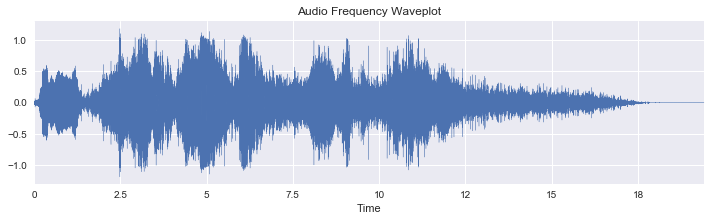

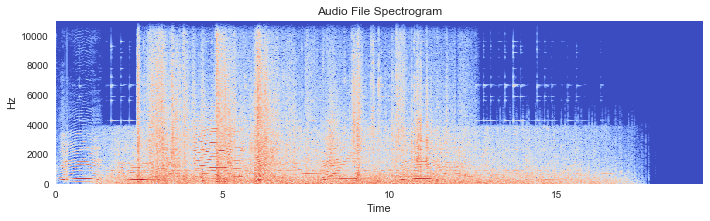

In [12]:
% run py-script/run_example.py

It is important to mention that the dataset has a rather diverse distribution of audio duration that presented a certain modeling challenge (as compared to more normalized classification problems where the vector space dimentionality is aligned across all datapoints). Below you can see the duration distirbution by label in the training dataset:

![](plots/violin_plot_duration.png)

In the preprocessing stages, we have addressed that concern by testing a number of different normalization techniques to represent the audio files within the same dimention. Those techniques included:
1. Choosing optimal max length (net strong outliers) and padding other audio files with silence to reach equal size
2. Choosing optimal length (net strong outliers) and trimming all larger audio files to chosen length (dropping anything below benchmark)
3. Choosing optimal length (net strong outliers) and trimming all larger audio files to chosen length (padding anything below benchmark)

Moving forward with the analysis, we have kept in mind that those preprocessing approaches may have introduced a certain bias to our dataset that might need to be taken into consideration during critisism stages.

In order to run this notebook in a reasonable amount of time, we will be importing a small subset of the data post preprocessing (each audio file represented as a normalized frequency vector) rather than the entire dataset. Nonetheless, the visual and numerical results presented in the following sections were based on the calculations made on the entire dataset.

In [67]:
# importing the sample audio files vector representations post preprocessing
train_data = feather.read_dataframe('data_overview/train_data.feather')
test_data = feather.read_dataframe('data_overview/test_data.feather')

## Box's Loop: First Iteration

### Model: Probabilistic PCA

## The Model

Consider a data set $\mathbf{X} = \{\mathbf{x}_n\}$ of $N$ data
points, where each data point is $D$-dimensional, $\mathbf{x}_n \in
\mathbb{R}^D$. We aim to represent each $\mathbf{x}_n$ under a latent
variable $\mathbf{z}_n \in \mathbb{R}^K$ with lower dimension, $K <
D$. The set of principal axes $\mathbf{W}$ relates the latent variables to
the data.

Specifically, we assume that each latent variable is normally distributed,

\begin{equation*}
\mathbf{z}_n \sim N(\mathbf{0}, \mathbf{I}).
\end{equation*}

The corresponding data point is generated via a projection,

\begin{equation*}
\mathbf{x}_n \mid \mathbf{z}_n
\sim N(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I}),
\end{equation*}

where the matrix $\mathbf{W}\in\mathbb{R}^{D\times K}$ are known as
the principal axes. In probabilistic PCA, we are typically interested in
estimating the principal axes $\mathbf{W}$ and the noise term
$\sigma^2$.

Probabilistic PCA generalizes classical PCA. Marginalizing out the the
latent variable, the distribution of each data point is

\begin{equation*}
\mathbf{x}_n \sim N(\mathbf{0}, \mathbf{W}\mathbf{W}^\top + \sigma^2\mathbf{I}).
\end{equation*}

Classical PCA is the specific case of probabilistic PCA when the
covariance of the noise becomes infinitesimally small, $\sigma^2 \to 0$.

We set up our model below. In our analysis, we assume $\sigma$ is known, and
instead of point estimating $\mathbf{W}$ as a model parameter, we
place a prior over it in order to infer a distribution over principal
axes. [1][2]

### Variational Inference

We use variational inference, where the posterior distribtion $p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X})$ is approximated using a variational distribution $q(\mathbf{W}, \mathbf{Z})$ parametrised by $\boldsymbol{\lambda}$. The aim is to find the variational parameters $\boldsymbol{\lambda}$ that _minimize_ the KL divergence between q and the posterior, $\mathrm{KL}(q(\mathbf{W}, \mathbf{Z}) \mid\mid p(\mathbf{W}, \mathbf{Z} \mid \mathbf{X}))$, or equivalently, that _maximize_ the evidence lower bound, $\mathbb{E}_{q(\mathbf{W},\mathbf{Z};\boldsymbol{\lambda})}\left[ \log p(\mathbf{W},\mathbf{Z},\mathbf{X}) - \log q(\mathbf{W},\mathbf{Z}; \boldsymbol{\lambda}) \right]$.

For the purpose of increasing the running time, the following code only applies the model on two labels (while working with 41 in the actual dataset) with 10 audio files each. Nontheless, the results reported in criticism are based on the entire dataset analysis. 

In [75]:
% run py-script/ppca.py
for label in train_data['label'].unique():
    print("Training PPCA for label: {}".format(label))
    x_train = train_data.loc[train_data['label']==label].copy()
    y_train = x_train.pop('label')
    
    x_train = x_train.transpose() 
    data_dim = x_train.shape[0]
    num_datapoints = x_train.shape[1]
    
    training_result = train_ppca(x_train, data_dim, latent_dim, num_datapoints, stddv_datapoints)
    training_results.append((label, training_result))

Training PPCA for label: Acoustic_guitar


KeyboardInterrupt: 

### Critisism

The proposed framework in then criticised by applying two different approaches:

1. Based on the derived Probabilistic PCA parameters, we are able to pull samples from the generated distributions for each label. Our expectation is that the sample audio waves should reseble (sound) similarly to those in their corresponding classes.
2. The classification accuracy can be estimated by calculating individual label probabilities of each test data point (audio file) while assigning the label with highest returned probability. The final label assignment in then compared to the true test labels.

Applying the first method, we pull a sample audio file to assess its audio resemblence.

Generated Audio File for: Acoustic Guitar


<Figure size 432x288 with 0 Axes>

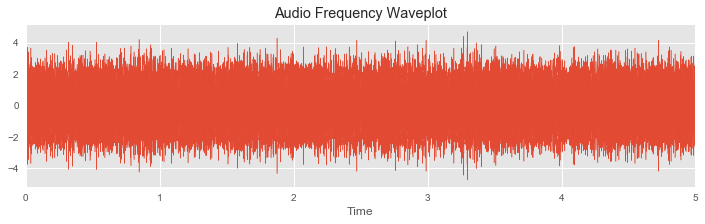

In [72]:
% run py-script/play_generated_sample.py
play_sample(training_results)

Unfortunately, listening back to the file, it sounds very different than expected (acoustic guitar). Given poor performance of the sampled distribution, we do not expect the classification accuracy rate to be high. Nonetheless, to establish a benchmark for future iterations, we have calculated it below. 

In [73]:
% run py-script/accuracy_calc.py
#sess = tf.InteractiveSession()
y_test = test_data['label']
y_test = y_test.replace({'Acoustic_guitar': 0, 'Laughter': 1})
x_test = test_data.drop(['label'], axis=1)
label_probabilities = calculate_probability(training_results, 2, latent_dim, stddv_datapoints, np.array(x_test))
assignments = assign_class(label_probabilities)
test_accuracy = accuracy_score(y_test, assignments)
print('Accuracy Score on Test Set: {}%'.format(test_accuracy*100))

Accuracy Score on Test Set: 33.33333333333333%


<Figure size 432x288 with 0 Axes>

A pretty low benchmark! At this point we will be better off guessing. It is important to mention that when tested against the entire dataset, the accuracy rate was even lower due to multi-class complexity not reflected in the sample dataset used in this notebook(~25% on average). 

The poor performance of this model could be possibly explained by the fact that the latent dimentiality chosen for the model is too strict given the default complex matrix-dimentiality representing the audio files (more than 10,000 features). Testing this hypothesis, we looked at the accuracy rate movement based on different settings of latent dimentiality. Looking at the chart above, increase in dimentiality does not seem to provide for better classification accuracy. Therefore, this hypothesis does not seem to be likely.


![](plots/librosa_dim_accuracy.png)
 

As mentioned in the **Data** part of this notebook, we chose to apply the model on three different processing methodologies of the audio file. Let's look if they showed any difference in performance:

One last explaination could be that our data is simply not linearly separable. Therefore, using probabilistic PCA does not provide for the best method given the problem setting.

Taking into consideration both of those critiques, there is a clear need for a more complex model that:
1. Does a better job capturing the data (able to properly generate label samples that are audible)
2. Runs more efficiently

Hence, for the next iteration of the Box's loop we chose to test variational autoencode approach (VAE).

## Box's Loop: Second Iteration

### Model: VAE

A variational autoencoder (VAE) implies a specific probability model of data $x$ and latent variables $z$ with the joint probability of the model expressed as 

$$p(x,z)=p(x∣z)p(z)$$

The generative process is defined as follows, for each datapoint:

1. Draw latent variables $z_{i}∼p(z)$
2. Draw datapoint $x_{i}∼p(x∣z)$

The above logic can also be represented as a graphical model:

![](plots/graph_model_vae.png)


Looking at the graph, the latent variables are drawn from a prior $p(z)$. The data $x$ have a likelihood $p(x∣z)$ that is conditioned on latent variables $z$. The model defines a joint probability distribution over data and latent variables: $p(x,z)$. We can then decompose this into the likelihood and prior: $p(x,z)=p(x∣z)p(z)$. 

### Variational Inference

Variational inference approximates the posterior with a family of distributions qλ(z∣x). The variational parameter λ indexes the family of distributions.
We can use the Kullback-Leibler divergence, which measures the information lost when using q to approximate p (in units of nats):
KL(qλ(z∣x)∣∣p(z∣x))=E​q​​ [logq​λ​​ (z∣x)]−E​q​​ [logp(x,z)]+logp(x)
Our goal is to find the variational parameters λ that minimize this divergence. The optimal approximate posterior is thus q​λ​∗​​ (z∣x)=argmin​λ​​ KL(q​λ​​ (z∣x)∣∣p(z∣x)).

We need one more ingredient for tractable variational inference. Consider the following function: ELBO(λ)=E​q​​[logp(x,z)]−E​q​​ [logq​λ​​ (z∣x)].
Notice that we can combine this with the Kullback-Leibler divergence and rewrite the evidence as logp(x)=ELBO(λ)+KL(q​λ​​ (z∣x)∣∣p(z∣x)).
By Jensen’s inequality, the Kullback-Leibler divergence is always greater than or equal to zero. This means that minimizing the Kullback-Leibler divergence is equivalent to maximizing the ELBO.

In the variational autoencoder model, there are only local latent variables (no datapoint shares its latent z with the latent variable of another datapoint). So we can decompose the ELBO into a sum where each term depends on a single datapoint. This allows us to use stochastic gradient descent with respect to the parameters λ. The ELBO for a single datapoint in the variational autoencoder is:
ELBO​i​​ (λ)=E​q​λ​​ (z∣x​i​​ )​​ [logp(x​i​​ ∣z)]−KL(q​λ​​ (z∣x​i​​ )∣∣p(z)).

### Criticism

## Box's Loop: Third Iteration

### Model

### Inference

### Critisism

## Conclusion

## References

1. Tipping, M. E., & Bishop, C. M. (1999). Probabilistic principal component analysis. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 61(3), 611–622.
2. Edward. Probabilistic PCA Tutorial. http://edwardlib.org/tutorials/probabilistic-pca
3. Doersch, C. (2016). Tutorial on Variational Autoencoders. CoRR, abs/1606.05908.
4. Variational Autoencoder Tutorial. https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
5. Dimitris G. Tzikass, Aristidis et. al. The Variational Approximation for Bayesian Inference.
6. Kevin P. Murphy. Machine Learning, A Probabilistic Perspective, Chapters 11 and 21.
7. Christopher M. Bishop. Pattern Recognition and Machine Learning, Chapters 9 and 10.
8. Diederik P Kingma, Max Welling Auto-Encoding Variational Bayes.
9. Gómez-Bombarelli et. al. Automatic chemical design using a data-driven continuous representation of molecules.
10. François Chollet. Deep Learning with Python.